# CNN 手写数字辨识

### Load data

In [39]:
import torch
import numpy as np
import torchvision

log_interval = 10
batch_size_train = 64
batch_size_test = 1000
n_epochs = 3

# disable cuDNN nondeterministic algorithms
torch.backends.cudnn.enabled = False

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/Desktop', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train,
  shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/Desktop', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

### Show img

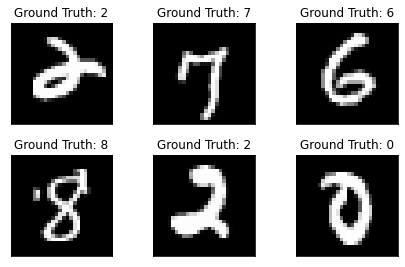

In [40]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

### Build Model

In [41]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        # 1 * 28 * 28
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # 12 * 12 * 10
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # 4 * 4 * 20
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = NNModel()
opt = optim.Adam(model.parameters())

### Define Train and Test function

In [42]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [43]:
def train(epoch):
    print("Begin train model...")
    print('iter,\tloss,\tacc')
    for batch_idx, (data, target) in enumerate(train_loader):
        y_hat = model(data)
        loss = F.nll_loss(y_hat,target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_losses.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [44]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

### Run Model

In [45]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/Users/jackjun/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


ValueError: Expected input batch_size (2250) to match target batch_size (1000).

### Evaluating the Model's Performance

ValueError: x and y must be the same size

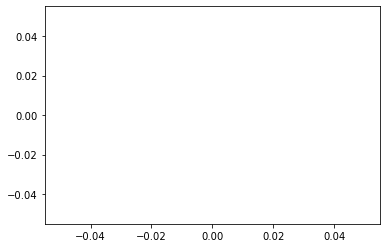

In [13]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

### Save Model State

In [ ]:
torch.save(model.state_dict(), './cnn.model')